Check the quality of spike train generation and augmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen, arb_spk_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

In [3]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [4]:
data[data['ptl_idx']==3].head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
79,3,2,0,2,0,60,1.0,5.0,-115.614439,-5,8.242655,0.0,60.0
80,3,2,0,2,0,60,1.0,5.0,-115.514279,-5,-8.423933,0.0,60.0
81,3,2,0,2,0,60,1.0,5.0,-104.513200,-5,0.996460,0.0,60.0
82,3,2,0,2,0,60,1.0,5.0,-82.919929,-5,7.876141,0.0,60.0
83,3,2,0,2,0,60,1.0,5.0,-93.891549,-5,-6.446189,0.0,60.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


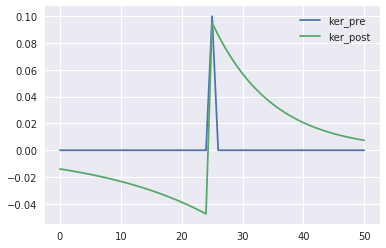

In [10]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen(scale_left=0.05, scale_right=0.1, tau_left=40, tau_right=20, scale=0.1)
ker_test.kernel_scale = np.ones(2)
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bi_exp_ker(), label='ker_post')
plt.legend()

In [11]:
# Generate data
ptl_list = [1]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10])

In [12]:
spk_pairs.shape

(450, 30000, 2)

In [13]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    loci_pre.append(loci_pre_tmp)
    loci_post.append(loci_post_tmp)
    dt_mean.append(np.mean(loci_pre_tmp - loci_post_tmp))

sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [14]:
def raster(event_times_list, trial_length,  **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial[trial_length]*2, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


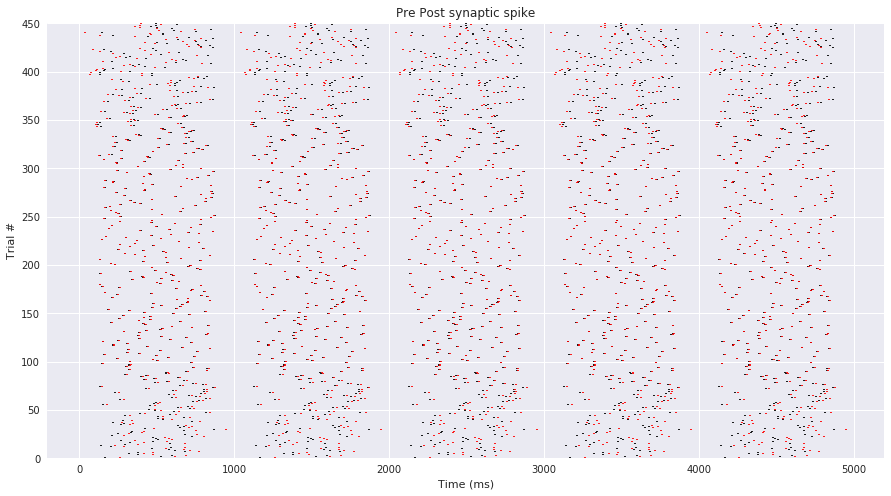

In [15]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,5)
ax = raster(loci_pre_2, trial_length)
ax = raster(loci_post_2,trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
fig.show()

In [16]:
# Generate data
ptl_list = [2,4]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10,10])
spk_pairs.shape

(380, 30000, 2)

In [17]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if len(loci_pre_tmp) == len(loci_post_tmp) * 2:   # Pre-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp - loci_pre_tmp[index_pre]))
    elif len(loci_post_tmp) == len(loci_pre_tmp) * 2:   # Post-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post] - loci_pre_tmp))
    else:
        print('Wrong length!!')
        
sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


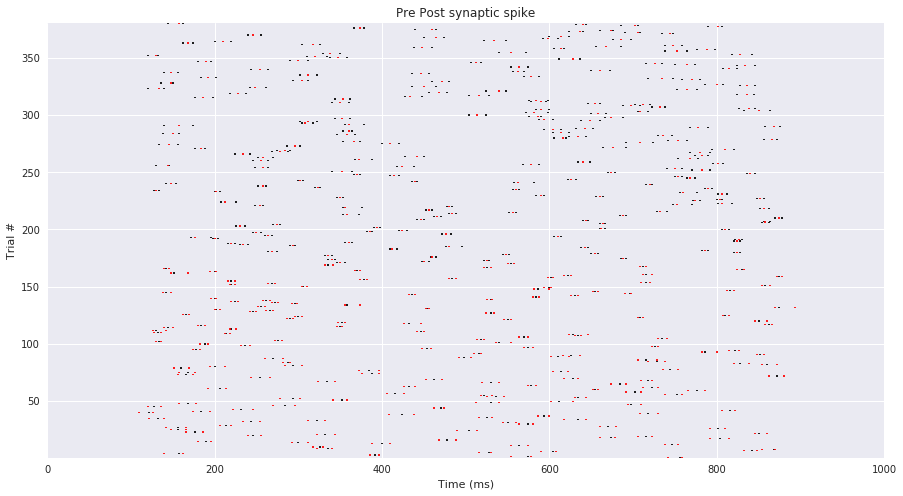

In [18]:
fig = plt.figure(figsize=(15, 8))
trial_length1 = np.arange(0,10)
trial_length2 = np.arange(0,5)
ax = raster(loci_pre_2, trial_length1)
ax = raster(loci_post_2, trial_length2, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [19]:
# Generate data
ptl_list = [3]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10])
spk_pairs.shape

(600, 30000, 2)

In [20]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
# spk_pairs.shape[0]
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if loci_pre_tmp[0] < loci_post_tmp[0]:  # Pre-post-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_pre+1] - loci_pre_tmp[index_pre]) * -1)
    elif loci_pre_tmp[0] > loci_post_tmp[0]:   # Post-pre-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post+1] - loci_post_tmp[index_post]))
        
sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [21]:
loci_post_tmp 

array([   83,    88,   583,   588,  1083,  1088,  1583,  1588,  2083,
        2088,  2583,  2588,  3083,  3088,  3583,  3588,  4083,  4088,
        4583,  4588,  5083,  5088,  5583,  5588,  6083,  6088,  6583,
        6588,  7083,  7088,  7583,  7588,  8083,  8088,  8583,  8588,
        9083,  9088,  9583,  9588, 10083, 10088, 10583, 10588, 11083,
       11088, 11583, 11588, 12083, 12088, 12583, 12588, 13083, 13088,
       13583, 13588, 14083, 14088, 14583, 14588, 15083, 15088, 15583,
       15588, 16083, 16088, 16583, 16588, 17083, 17088, 17583, 17588,
       18083, 18088, 18583, 18588, 19083, 19088, 19583, 19588, 20083,
       20088, 20583, 20588, 21083, 21088, 21583, 21588, 22083, 22088,
       22583, 22588, 23083, 23088, 23583, 23588, 24083, 24088, 24583,
       24588, 25083, 25088, 25583, 25588, 26083, 26088, 26583, 26588,
       27083, 27088, 27583, 27588, 28083, 28088, 28583, 28588, 29083,
       29088, 29583, 29588])

In [22]:
loci_pre_tmp

array([   79,    90,   583,   590,  1080,  1090,  1579,  1590,  2083,
        2091,  2583,  2590,  3081,  3090,  3581,  3591,  4081,  4090,
        4579,  4589,  5081,  5089,  5581,  5589,  6081,  6090,  6581,
        6590,  7081,  7090,  7582,  7588,  8081,  8091,  8580,  8589,
        9081,  9088,  9581,  9591, 10081, 10089, 10583, 10589, 11082,
       11090, 11581, 11590, 12081, 12090, 12580, 12590, 13079, 13090,
       13579, 13588, 14082, 14089, 14581, 14590, 15082, 15090, 15581,
       15590, 16082, 16088, 16581, 16591, 17081, 17088, 17583, 17591,
       18081, 18090, 18583, 18590, 19081, 19090, 19581, 19590, 20081,
       20090, 20580, 20590, 21082, 21088, 21579, 21591, 22079, 22089,
       22581, 22591, 23082, 23090, 23581, 23590, 24079, 24090, 24581,
       24588, 25080, 25091, 25580, 25588, 26082, 26089, 26579, 26592,
       27081, 27088, 27581, 27590, 28081, 28090, 28581, 28589, 29079,
       29089, 29581, 29590])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


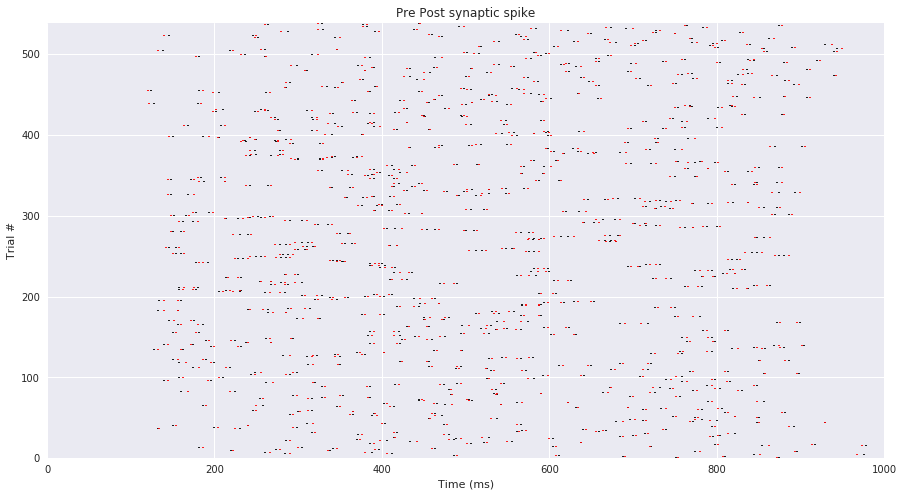

In [39]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,10)
ax = raster(loci_pre_2, trial_length)
ax = raster(loci_post_2, trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,1000])
fig.show()

In [67]:
# Drop long protocl that can be replaced by STDP
data.drop(data[data['ptl_occ'] == 50].index, axis=0, inplace=True)

In [68]:
# Generate data
ptl_list = [5]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10])
spk_pairs.shape

(40, 75000, 2)

In [69]:
data[data['ptl_idx']==5]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
144,5,5,10,5,10,15,0.1,10.0,0.0,0,115.724663,9.195363,150.0
145,5,5,20,5,20,15,0.1,10.0,0.0,0,131.265503,12.873509,150.0
146,5,5,40,5,40,15,0.1,10.0,0.0,0,154.160944,10.114900,150.0
147,5,5,50,5,50,15,0.1,10.0,0.0,0,156.368508,25.747018,150.0


In [70]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    loci_pre.append(loci_pre_tmp)
    loci_post.append(loci_post_tmp)
    dt_mean.append(np.mean(loci_pre_tmp - loci_post_tmp))

sort_index = np.argsort(dt_mean)
loci_pre_2 = [loci_pre[i] for i in sort_index]
loci_post_2 = [loci_post[i] for i in sort_index]

In [71]:
loci_pre_tmp

array([ 4161,  4171,  4181,  4191,  4201,  9161,  9171,  9181,  9191,
        9201, 14161, 14171, 14181, 14191, 14201, 19161, 19171, 19181,
       19191, 19201, 24161, 24171, 24181, 24191, 24201, 29161, 29171,
       29181, 29191, 29201, 34161, 34171, 34181, 34191, 34201, 39161,
       39171, 39181, 39191, 39201, 44161, 44171, 44181, 44191, 44201,
       49161, 49171, 49181, 49191, 49201, 54161, 54171, 54181, 54191,
       54201, 59161, 59171, 59181, 59191, 59201, 64161, 64171, 64181,
       64191, 64201, 69161, 69171, 69181, 69191, 69201, 74161, 74171,
       74181, 74191, 74201])

In [72]:
loci_post_tmp

array([ 4167,  4176,  4186,  4198,  4207,  9166,  9177,  9186,  9197,
        9211, 14167, 14181, 14186, 14198, 14207, 19164, 19177, 19191,
       19198, 19206, 24165, 24173, 24187, 24197, 24207, 29166, 29176,
       29185, 29197, 29207, 34162, 34176, 34187, 34196, 34204, 39168,
       39176, 39184, 39196, 39205, 44169, 44176, 44185, 44196, 44206,
       49165, 49175, 49185, 49196, 49205, 54169, 54178, 54187, 54197,
       54206, 59165, 59175, 59186, 59199, 59208, 64167, 64175, 64186,
       64198, 64208, 69168, 69176, 69183, 69196, 69204, 74163, 74175,
       74190, 74196, 74210])

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


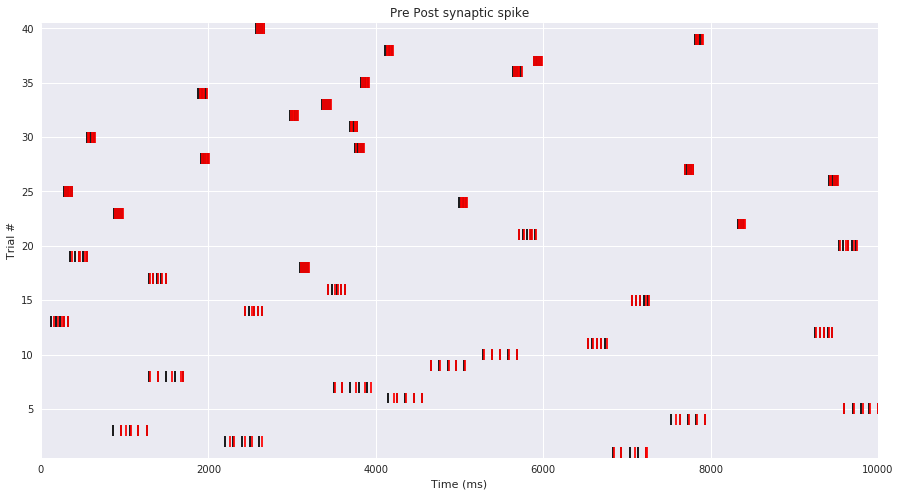

In [75]:
fig = plt.figure(figsize=(15, 8))
trial_length = np.arange(0,20)
ax = raster(loci_pre_2[:500], trial_length)
ax = raster(loci_post_2[:500], trial_length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,10000])
fig.show()

### Generate STDP spike trains and save

In [ ]:
# # Visualize kernel
# from modelval.kernel import KernelGen
# plt.figure(figsize=(5,3))
# ker_test = KernelGen()
# ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=5, scale=0.1, shift=-1)
# ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=7, scale=0.15)
# ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=10, scale=0.5, shift=-1)
# plt.plot(ker_test.kernel_pre, label='ker_pre')
# plt.plot(ker_test.kernel_post, label='ker_post')
# plt.plot(ker_test.kernel_post_post, label='ker_post_post')
# plt.legend()

In [ ]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

In [ ]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Visu_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms
tau_post_post = tau[3]/reso_set # ms

ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=tau_pre_post, scale=1, shift=-1)
ker_pre_norm = np.linalg.norm(ker_test.kernel_pre, ord=2)
ker_test.kernel_pre = ker_test.kernel_pre/ker_pre_norm
ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=tau_post_pre, scale=1)
ker_post_norm = np.linalg.norm(ker_test.kernel_post, ord=2)
ker_test.kernel_post = ker_test.kernel_post/ker_post_norm
ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=tau_post_post, scale=1, shift=-1)
ker_post_post_norm = np.linalg.norm(ker_test.kernel_post_post, ord=2)
ker_test.kernel_post_post = ker_test.kernel_post_post/ker_post_post_norm
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()
kernel_scale = np.array([a[0]*ker_pre_norm, a[2]*ker_post_norm, a[3]/a[0]*ker_post_post_norm])
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2), kernel_scale)

In [ ]:
kernel_hipp = {}
kernel_hipp['pre_post'] = ker_test.kernel_pre
kernel_hipp['post_pre'] = ker_test.kernel_post
kernel_hipp['post_post'] = ker_test.kernel_post_post
kernel_hipp['post_post'] = ker_test.kernel_post_post

In [ ]:
np.save('/data/kernel_hipp.npy', kernel_hipp)

In [ ]:
test_kernel = np.load('/data/kernel_hipp_save.npy')

In [ ]:
# Generate data
ptl_list = [1]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data[data['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
STDP_pairs, _ = arb_w_gen(df=data_select, ptl_list=[1,2,3,4], spk_len=spk_len, kernel=ker_test, aug_times=[10], net_type='triplet')

### Generate hippocampal spike trains and save

In [ ]:
# Generate data
ptl_list = [1,2,3,4]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data[data['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

# Insert values for Quadruplet protocol
for i in range(len(dt)):
    if np.abs(dt[i])>10:
        new_try2 = data[data['ptl_idx']==3].iloc[0]
        new_try2['dt2'] = dt[i]
        data_select = data_select.append(new_try2, ignore_index=True)
    
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
hippo_pairs, _ = arb_w_gen(df=data_select, ptl_list=[1,2,3,4], spk_len=spk_len, kernel=ker_test, aug_times=[10,10,10,10], net_type='triplet')

### Generate Visual Cortex spike trains and save

In [ ]:
# Generate data
ptl_list = [1,5,6,7,8]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data_select[data_select['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)
    
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
VC_pairs, _ = arb_w_gen(df=data_select, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[5,20,20,20,20], net_type='triplet')

In [ ]:
# Save the data to file
np.save('/data/STDP_spike_pairs.npy', STDP_pairs)

In [ ]:
# Save the data to file
np.save('/data/Hippo_spike_pairs.npy', hippo_pairs)

In [ ]:
# Save the data to file
np.save('/data/Visual_cortex_spike_pairs.npy', VC_pairs)